In [1]:
import os
from dotenv import load_dotenv
from pathlib import Path
from neo4j import GraphDatabase

In [2]:
load_dotenv(dotenv_path=Path("../../00_src/.env"))

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = os.getenv("NEO4J_URI")
AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

In [3]:
database = "neo4j"

In [4]:
def clear_db_tx(tx):
    # delete all nodes with relationships
    tx.run("""
        MATCH (a) -[r] -> () DELETE a, r
    """) 
    # delete nodes that have no relationships
    tx.run("""
        MATCH (a) DELETE a
    """)

def clear_db():
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        with driver.session(database=database) as session:
            session.execute_write(clear_db_tx)
            print("cleared all nodes in " + database)

In [5]:
clear_db()

cleared all nodes in neo4j


In [6]:
def execute_write_tx(tx, cypher):
    tx.run(cypher) 

def execute_write(cypher):
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        with driver.session(database=database) as session:
            session.execute_write(execute_write_tx, cypher)
            print("successful")

In [7]:
execute_write("""
CREATE (a:FirstNode { Tag : "This is a Node" })
    """)

successful


In [8]:
def execute_query(query: str, **kwargs: any):
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        records, summary, keys = driver.execute_query(
        query,
        **kwargs,
        database_=database,
        )
    return records, summary, keys

In [9]:
execute_query(
    """
MATCH (n:FirstNode) RETURN n LIMIT $limit
    """,
    limit = 25
)

([<Record n=<Node element_id='4:e2c4b0ec-a2c1-49c2-9dc4-b936b7c2ec5a:0' labels=frozenset({'FirstNode'}) properties={'Tag': 'This is a Node'}>>],
 ['n'])

In [10]:
execute_write("""
CREATE (:Player {id: 1, tag:"Player"});
    """)

execute_write("""
CREATE (:Action {id:1, player_id:1, tag:"Up"}),
       (:Action {id:2, player_id:1, tag:"Down"}),
       (:Action {id:3, player_id:1, tag:"Left"}),
       (:Action {id:4, player_id:1, tag:"Right"});
 """)

execute_write("""
MATCH (a:Action),(p:Player)
  WHERE a.player_id = p.id
CREATE (p)-[:CAN_MOVE]->(a);
 """)

successful
successful
successful


cleared all nodes in neo4j


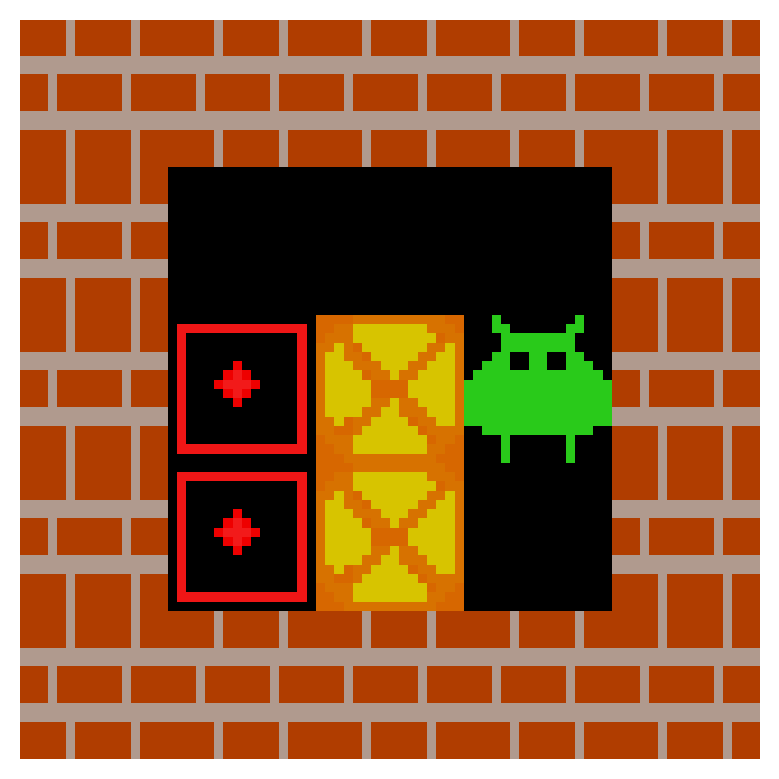

In [40]:
from gym_sokoban.envs import SokobanEnv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

clear_db()

# For constant same enviroment the seed can be set:
env = SokobanEnv(dim_room=(10, 10), max_steps=40, num_boxes=4, num_gen_steps=None, reset=True)
env.seed(1)

# For a fully self defined map the reset method can be overwritten:
class SokobanEnvFixated(SokobanEnv):     
    def reset(self, second_player=False, render_mode='rgb_array'):

        self.room_fixed = np.array([[0, 0, 0, 0, 0],
                                    [0, 1, 1, 1, 0],
                                    [0, 2, 1, 1, 0],
                                    [0, 2, 1, 1, 0],
                                    [0, 0, 0, 0, 0]])
        self.room_state = np.array([[0, 0, 0, 0, 0],
                                    [0, 1, 1, 1, 0],
                                    [0, 2, 4, 1, 0],
                                    [0, 2, 4, 5, 0],
                                    [0, 0, 0, 0, 0]])
        self.box_mapping = {(2, 1): (2, 2), (3, 1): (3, 2)}

        self.player_position = np.argwhere(self.room_state == 5)[0]
        self.num_env_steps = 0
        self.reward_last = 0
        self.boxes_on_target = 0

        starting_observation = self.render(render_mode)
        return starting_observation
  
env = SokobanEnvFixated(dim_room=(5, 5), max_steps=40, num_boxes=2, num_gen_steps=None, reset=True)
env.step(1)

def render_state(env, mode="rgb_array"):
    """Renders the Sokoban environment as image and displays it."""
    image = env.render(mode)

    plt.figure(dpi=200) 
    plt.imshow(image)
    plt.axis('off')
    plt.show()

render_state(env)

In [41]:
x =1
y = 2
tag = "Floor ({x}, {y})".format(x=x, y=y)
# double brackets {{}} are needed to make {} and not be influenced by format()
"""
    CREATE (:Floor {{id: 1, tag:"{tag}"}});
""".format(tag=tag)

'\n    CREATE (:Floor {id: 1, tag:"Floor (1, 2)"});\n'

In [42]:
FLOOR = 1
BOX_TARGET = 2
id = 1
nodes =[]
for y in range(len(env.room_fixed)):
        for x in range(len(env.room_fixed[y])):
                tile = env.room_fixed[y][x]
                if tile == FLOOR or tile == BOX_TARGET:
                        tag = "Floor [{x},{y}]".format(x=x, y=y)
                        has_box_target = tile == BOX_TARGET
                        nodes.append("(:Floor {{id: {id}, x:{x}, y:{y}, has_box_target:{has_box_target}, tag:\"{tag}\"}})".format(id=id, x=x, y=y, has_box_target=has_box_target, tag=tag))
                        id+=1
cypher = "CREATE " + ",".join(nodes) + ";"
execute_write(cypher)

successful


In [43]:
execute_write("""
MATCH (o1:Floor),(o2:Floor)
  WHERE (o1.x = o2.x AND o1.y = o2.y-1)
     OR (o1.x = o2.x AND o1.y = o2.y+1)
     OR (o1.x = o2.x-1 AND o1.y = o2.y)
     OR (o1.x = o2.x+1 AND o1.y = o2.y)
CREATE (o1)-[:CAN_GO_TO]->(o2);
 """)

successful


In [44]:
BOX_ON_TARGET = 3
BOX = 4
PLAYER = 5

player_id = 1
box_id = 1
nodes =[]
for y in range(len(env.room_state)):
        for x in range(len(env.room_state[y])):
                tile = env.room_state[y][x]
                if tile == BOX_ON_TARGET or tile == BOX:
                        tag = "Box"
                        is_on_target = tile == BOX_ON_TARGET
                        nodes.append("(:Box {{id: {id}, x:{x}, y:{y}, is_on_target:{is_on_target}, tag:\"{tag}\"}})".format(id=box_id, x=x, y=y, is_on_target=is_on_target, tag=tag))
                        box_id+=1
                elif tile == PLAYER:
                        tag = "Player"
                        nodes.append("(:Player {{id: {id}, x:{x}, y:{y}, tag:\"{tag}\"}})".format(id=player_id, x=x, y=y, tag=tag))
                        player_id+=1
cypher = "CREATE " + ",".join(nodes) + ";"
execute_write(cypher)

successful


In [45]:
execute_write("""
MATCH (p:Player),(f:Floor)
  WHERE p.x = f.x AND p.y = f.y
CREATE (p)-[:ON_TOP_OF]->(f);
 """)

execute_write("""
MATCH (b:Box),(f:Floor)
  WHERE b.x = f.x AND b.y = f.y
CREATE (b)-[:ON_TOP_OF]->(f);
 """)

successful
successful


In [46]:
targets = []
for target_position, box_position in env.box_mapping.items():
    targets.append("(b.x = {box_x} AND b.y = {box_y} AND f.x = {tar_x} AND f.y = {tar_y})".format(tar_x=target_position[1], tar_y=target_position[0], box_x=box_position[1], box_y=box_position[0]))
    
cypher = "MATCH (b:Box),(f:Floor) WHERE " + " OR ".join(targets) + " CREATE (b)-[:SHOULD_GO_TO]->(f);"
execute_write(cypher)

successful


In [50]:
actions = [(1, 0, -1, "Up"), (2, 0, 1, "Down"), (3, -1, 0, "Left"), (4, 1, 0, "Right")] #(action_id, dx, dy, tag)
find_player = lambda room_state: next((x, y) for y, row in enumerate(room_state) for x, val in enumerate(row) if val == 5)
in_bound = lambda array, n: n >= 0 and n < len(array)
pos_in_bound = lambda room_state, x, y: in_bound(room_state, y) and in_bound(room_state[0], x)
nodes =[]

player_pos = find_player(env.room_state)
for action in actions:
    dx, dy = action[1], action[2]
    player_x, player_y = player_pos[0] + dx, player_pos[1] + dy
    box_x, box_y = player_x + dx, player_y + dy
    can_move = pos_in_bound(env.room_state, player_x, player_y) and env.room_state[player_y, player_x] in [FLOOR, BOX_TARGET]
    can_push_box = env.room_state[player_y, player_x] in [BOX_ON_TARGET, BOX] and pos_in_bound(env.room_state, box_x, box_y) and env.room_state[box_y, box_x] in [FLOOR, BOX_TARGET]
    if can_move or can_push_box:
        nodes.append("(:Action {{id: {id}, dx:{dx}, dy:{dy}, tag:\"{tag}\"}})".format(id=action[0], dx=dx, dy=dy, tag=action[3]))

cypher = "CREATE " + ",".join(nodes) + ";"
execute_write(cypher)

execute_write("""
MATCH (p:Player),(a:Action)
CREATE (p)-[:CAN_MOVE]->(a);
 """)

successful
successful
